<a href="https://colab.research.google.com/github/Sertaky/pytorch/blob/main/01_PyTorch_Workflow_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch workflow

* 1- data ( prepare and load )
* 2- build model
* 3- fitting the model to data ( training )
* 4- making predections and evaluting model (inference )
* 5- saving and loading model
* 6- putting it all together

In [16]:
import torch
from torch import nn # nn contains all of pytorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

## 1- Data ( preparing and loading )

Data could be almost anything  ... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos
* DNA
* Text
* Audio

Machine learning is a game of two parts :

  1- Get data into a numerical representation.
  
  2- Build a model to learn patterns in that numerical representaion.

In [17]:
# y = bx + a ====> b--> slope , a--> interception with y when x = 0
#                  b--> weight, a--> bias

# Create known parameters
weight = 0.7
bias = 0.3

# create some data

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X),len(y)

(50, 50)

## Split data into training and test sets

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Let's create training and test set with our data .

In [18]:
# creat a train/test split
train_split = int(0.8 * len(X))
X_train ,y_trian = X[:train_split] , y[:train_split]
X_test , y_test  = X[train_split:] , y[train_split :]

len(X_train) , len(y_trian) , len(X_test) , len(y_test)

(40, 40, 10, 10)

## Let's create a function to visualize it.

In [19]:
def plot_predictions(train_data = X_train,
                     train_labels= y_trian,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None) :
  '''
  plots training data , test data and compares predictions.
  '''
  plt.figure(figsize = (10,7))

  # plot training data in blue
  plt.scatter(train_data , train_labels , c = 'b' , s=4 , label = 'Training data')

  # plot testing data in green
  plt.scatter(test_data , test_labels , c = 'g' , s=4 , label = 'Testing data')

  # Are there predictions ?
  if predictions is not None :
    # plot the predictions if they exist
    plt.scatter(test_data , predictions , c = 'r' , s=4 , label = 'Predictions')

  # show the legend
  plt.legend(prop = {'size': 14});



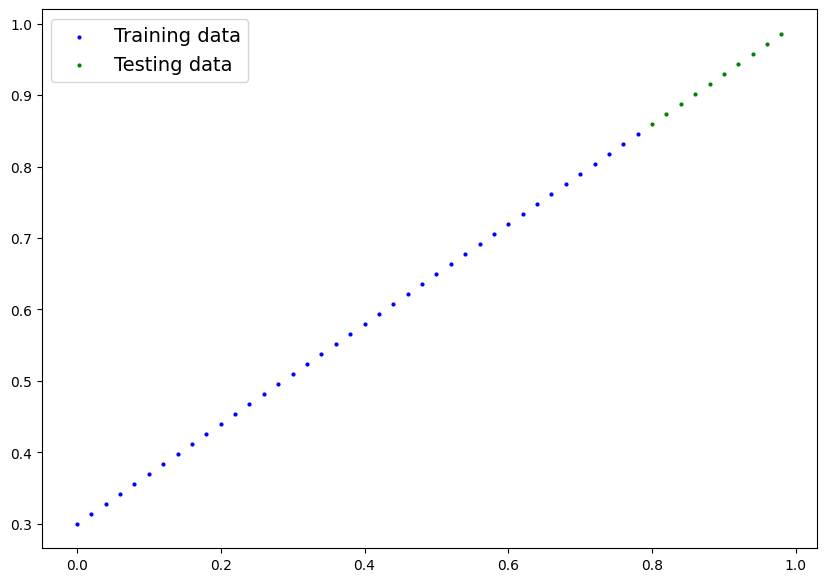

In [20]:
plot_predictions();

### 2 Build model
Now we've got some data, let's build a model to use the blue dots to predict the green dots.

What our model does ?

* start with random values (weigh & bias)
* look at training data and adjust the random values to better represent (or get closer to) the ideal values ( the weight & bias values we used to create the data )


How does it do so ?

   * 1- Gradient descent

   *2- Backpropagation

In [21]:
from torch import nn

# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials

* `torch.nn` - Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).

* `torch.nn.Parameter` -	Stores tensors that can be used with `nn.Module` If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

* `torch.nn.Module` -	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module` Requires a `forward()` method be implemented.

* `torch.optim` -	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

* `def forward()` -	All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above).

### Checking the contents of a PyTorch model

Now we have created a model , let's see what's inside....

So we can check our model parameters or what's inside our model using `.Parameters()`


In [22]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model  this is a subclass of `nn.Module`)
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [23]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

to check out model's predictive power , let's see how well is predicts `y_test` based on `X_test`

when we pass data through our model, it's going to run it through the `forward()` method

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the `forward()` method) faster.


Note: In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things, `torch.inference_mode()` is newer, potentially faster and preferred.

In [24]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [25]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

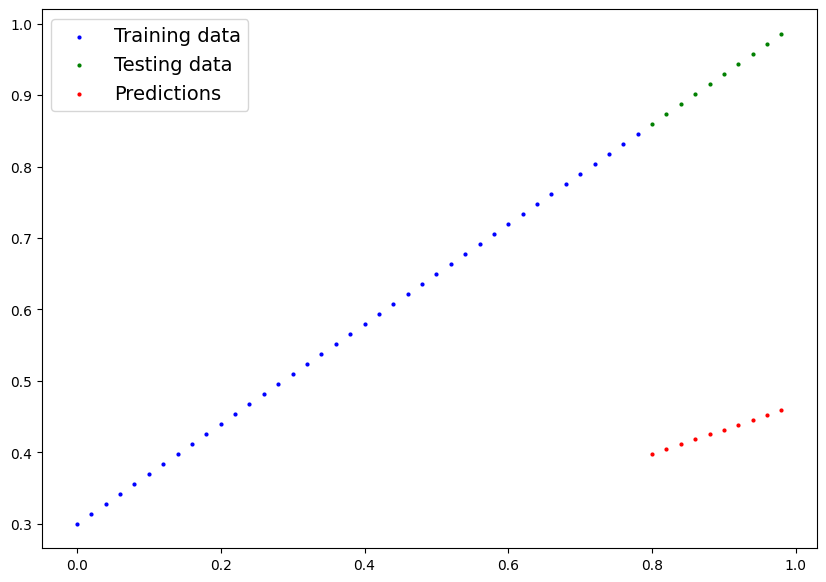

In [26]:
plot_predictions(predictions = y_preds)

### Train model

the whole idea of training is for a model to move from some *unknown* parameters (thses maybe random) to some *known* parameters.

or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a `loss function`.

* Note: Loss function may also be called cost function or criterion in different areas.

## things we need to train :

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, so lower is better.

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias ) to improve the loss

    ## Inside the optimizer you will often have to set two parameters :    
    *  `params` - is the target model parameters you'd like to optimize (e.
          g. the weights and bias values we randomly set before). for example
          `params = model_0.parameters()`
    * `lr` (learning rate) - ou'd like the optimizer to update the
       
       parameters at,
       higher means the optimizer will try larger updates (these can sometimes
       be too large and the optimizer will fail to work), lower means the
       optimizer will try smaller updates (these can sometimes be too small and
       the optimizer will take too long to find the ideal values). The learning
       rate is considered a hyperparameter (because it's set by a machine
       learning engineer). Common starting values for the learning rate are 0.
       01, 0.001, 0.0001, however, these can also be adjusted over time (this
       is called learning rate scheduling)   

## and specifically for pytorch, we need :     

* A training loop

* A testing loop

In [27]:
model_0.parameters()

<generator object Module.parameters at 0x79a0a35d5770>

In [34]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3757], requires_grad=True),
 Parameter containing:
 tensor([0.2288], requires_grad=True)]

In [29]:
# check out our model parameters ( a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [30]:
# setup a loss function

loss_fn = nn.L1Loss()

# setup optimizer ( stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr =0.01 ) # lr = learning rate = possibly the most important hyperparameter you can set

### Building a training loop ( and a testing loop ) in pytorch

A couple of things we need in a training loop :    
0. loop through the data
1. forward pass ( this involves data moving through our model's `forward()` function) to make predictions on data - also called forward propagation
2. calculate the loss ( compare forward pass predictions to ground truth labels )
3. optimizer zero grad
4. loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [35]:
from torch.autograd import backward
torch.manual_seed(42)

# an epoch is one loop through the data...
epochs = 200

# track different values
epoch_count = []
loss_values = []
test_loss_values =[]

### Training

# 0. loop through the data

for epoch in range (epochs):

  # set the model to training mode
  model_0.train()  # train mode in pytorch set all parameters that require gradients to require gradients

  # 1. forward pass
  y_pred = model_0(X_train)

  # 2. calculate the loss
  loss = loss_fn(y_pred , y_trian)
  #print(f'loss :{loss}')
  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. preform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. step the optimizer (preform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so .... we have to zero them above in step 3 for the next iteration of the loop

  ### Testing

  model_0.eval() # turns off different settings in the model not needed for evaluation / testing (dropout / batch norm layers)
  with torch.inference_mode():   # turns off gradient tracking & a couple more things behind the scene
  # with torch.no_grad(): # you may see in older pytorch code

   # 1. do forward pass
   test_pred = model_0(X_test)

   # 2. calculate loss
   test_loss = loss_fn(test_pred , y_test)

  # print out what's happenin
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f'Epoch: {epoch} | loss: {loss} | Test loss: {test_loss}')
    # print out model state_dic()
    print(model_0.state_dict())


Epoch: 0 | loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 10 | loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 20 | loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 30 | loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 40 | loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 50 | loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
Epoch: 60 | loss: 0.03476089984178543 | Test loss: 0.0805937647819519
OrderedDict([('weights', tensor([0.5288])), ('bias', tensor([0.3718]

In [36]:
weight , bias

(0.7, 0.3)

In [37]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

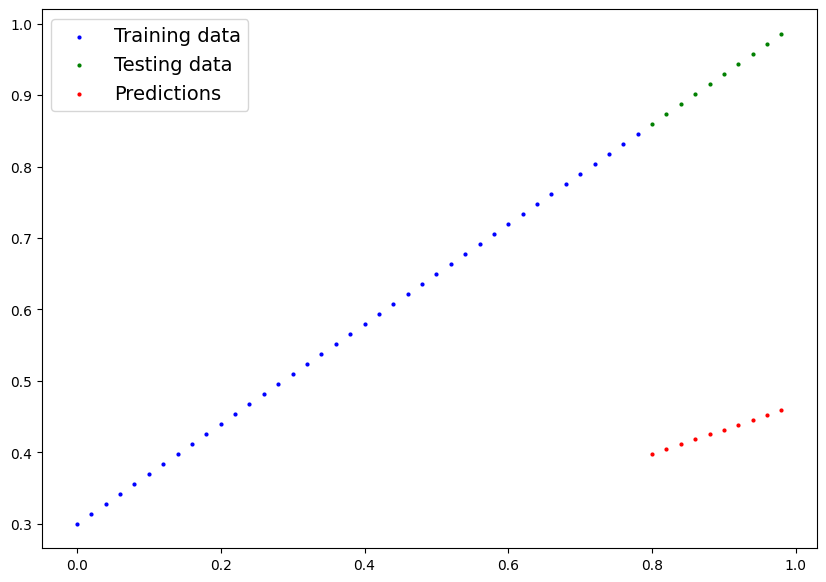

In [38]:
plot_predictions(predictions=y_preds)


In [39]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

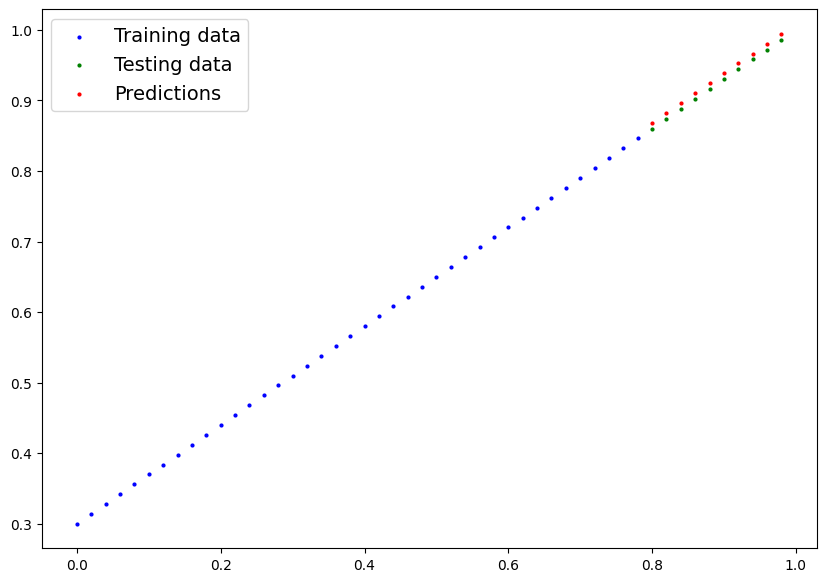

In [40]:
plot_predictions(predictions=y_preds_new)


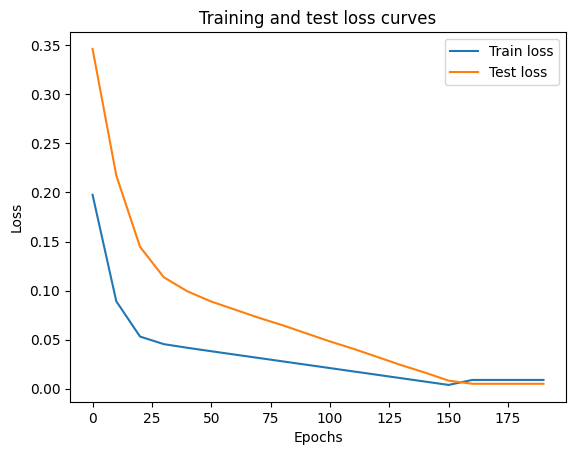

In [42]:
# Plot the loss curves
plt.plot(epoch_count, loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Saving a model in PyTorch

1. `torch.save()` - allows you to save a pytorch object in python's pickle format
2. `torch.load()` - allows you to load a saved pytorch object
3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved state dictionary

In [43]:
# saving our pytorch model

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [44]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1207 Aug 28 03:55 01_pytorch_workflow_model_0.pth


### Loading a saved PyTorch model's state_dict()
Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

Why call`torch.load()` inside `torch.nn.Module.load_state_dict()`?

Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and not the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a `subclass of nn.Module`).

In [45]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [46]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [47]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [51]:
# make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [49]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [50]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

6. ## Putting it all together

In [52]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.0.1+cu118'

## creat device-agnostic code

In [53]:
# setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

using device: cpu


## Data

In [54]:
# create some data using linear regression formla y = mx +a
weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# create X and y (features and labels )
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10] , y[:10]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [55]:
# split the data
train_split = int(0.8*len(X))
X_train , y_train = X[:train_split] , y[:train_split]
X_test , y_test = X[train_split:] , y[train_split:]
len(X_train) , len(y_trian) , len(X_test) , len(y_test)

(40, 40, 10, 10)

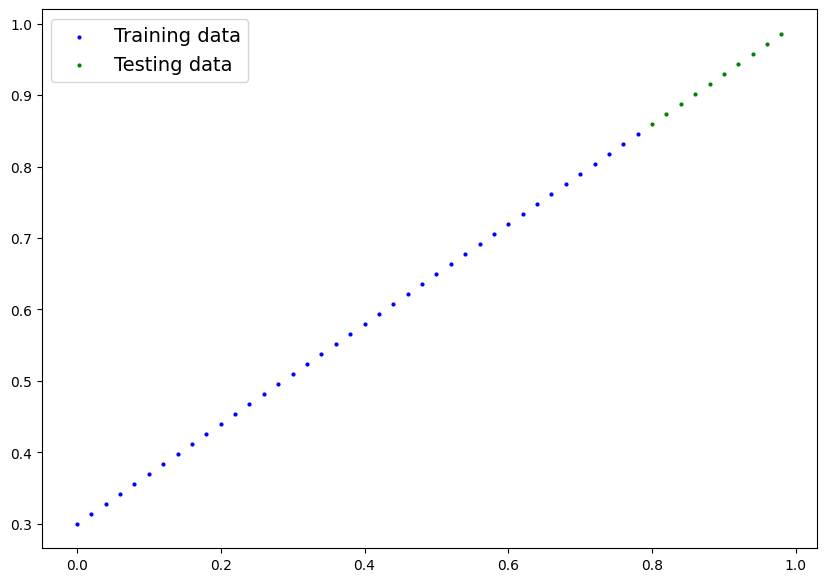

In [56]:
# plot the data
plot_predictions(X_train,y_train,X_test,y_test)

## Build pytorch linear model

In [57]:
# create linear model by subclassing nn.Module

class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # use nn.Linear() for creating the model paramters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self , x: torch.tensor) -> torch.tensor :
    return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1 , model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [58]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

## Training

In [59]:
# setup loss function
loss_fn = nn.L1Loss()

# setup optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.01)

In [60]:
# training loop
torch.manual_seed(42)

epochs = 200
for epoch in range (epochs):
  model_1.train()
  #forward pass
  y_pred = model_1(X_train)

  #calculate the loss
  loss = loss_fn(y_pred , y_train)

  #optimizer zero grade
  optimizer.zero_grad()

  #backpropagation
  loss.backward()

  # optimizer step
  optimizer.step()

  ### testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred , y_test)

  #print out what is happening

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f'Epoch: {epoch} | loss: {loss} | Test loss: {test_loss}')
  # print out model state_dic()
  print(model_0.state_dict())


Epoch: 0 | loss: 0.5551779866218567 | Test loss: 0.5739762187004089
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
Epoch: 10 | loss: 0.4399680495262146 | Test loss: 0.4392663538455963
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor(

In [61]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [62]:
weight ,bias

(0.7, 0.3)

## Making and evaluating prediction

In [63]:
# turn the model into evaluation mode
model_1.eval()

# make predictions on test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

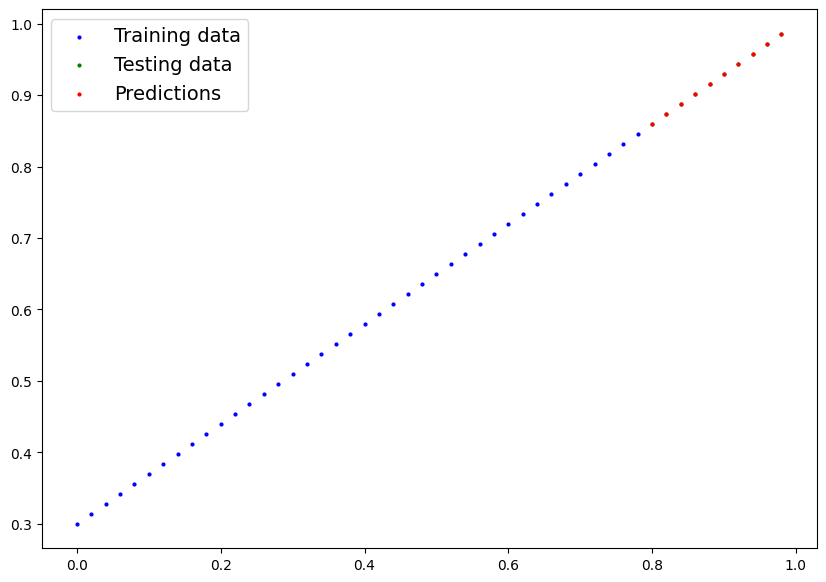

In [65]:
# check thee model visually
plot_predictions(predictions= y_preds.cpu())

## Saving and Loading a trained model

In [79]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [80]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [81]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [82]:
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [83]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [84]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [85]:
# evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])